# Udacity Self-Driving Nanodegree

## Vehicle Detection and Tracking

### Feature Extraction

In [1]:
import numpy as np
import cv2
import glob
import time
import csv
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from collections import deque
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from scipy.ndimage.measurements import label
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

%matplotlib inline

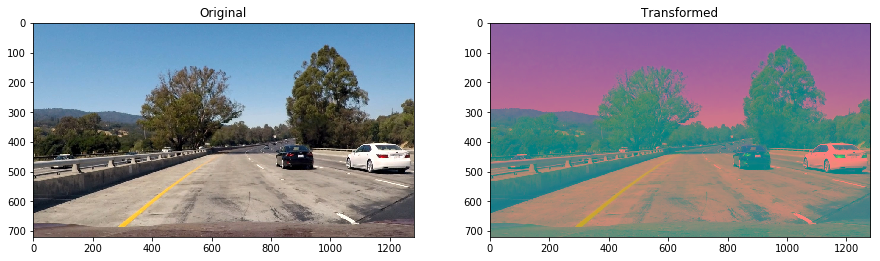

In [2]:
def show_img(original, transformed):
    grid, (axis1, axis2) = plt.subplots(1, 2, figsize=(15, 7))
    axis1.set_title('Original')
    axis1.imshow(original)
    axis2.set_title('Transformed')
    axis2.imshow(transformed)
    
# Input image needs to be in the RGB colorspace
def convert_color(img, conv='YCrCb'):
    if conv == 'YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if conv == 'Luv':
        return cv2.cvtColor(img, cv2.COLOR_RGB2Luv)
    
test_img = mpimg.imread('test_images/test1.jpg')
transformed = convert_color(np.copy(test_img))
show_img(test_img, transformed)

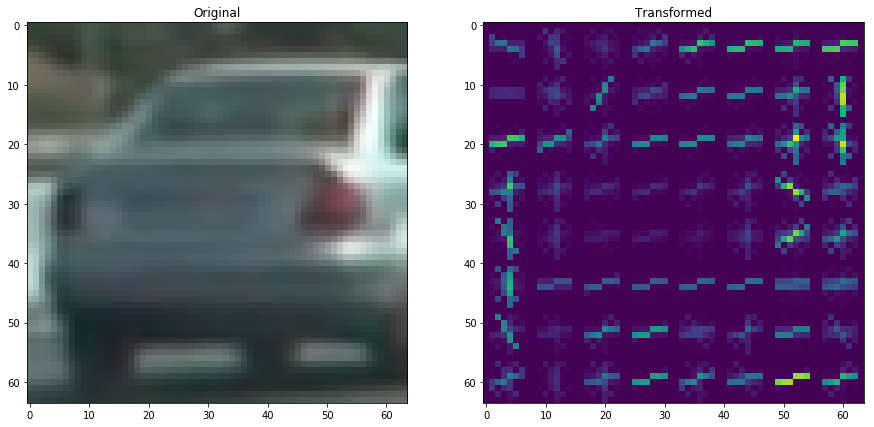

In [176]:
def get_hog_features(img, orient=9, pix_per_cell=8, cell_per_block=2,
                     vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=True,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=True,
                       visualise=vis, feature_vector=feature_vec)
        return features
    
test_img = mpimg.imread('test_images/vehicle.png')                              
features, hog_image = get_hog_features(test_img[:,:,2] , vis=True)
show_img(test_img, hog_image)
mpimg.imsave('output_images/vehicle_hog.jpg', hog_image)

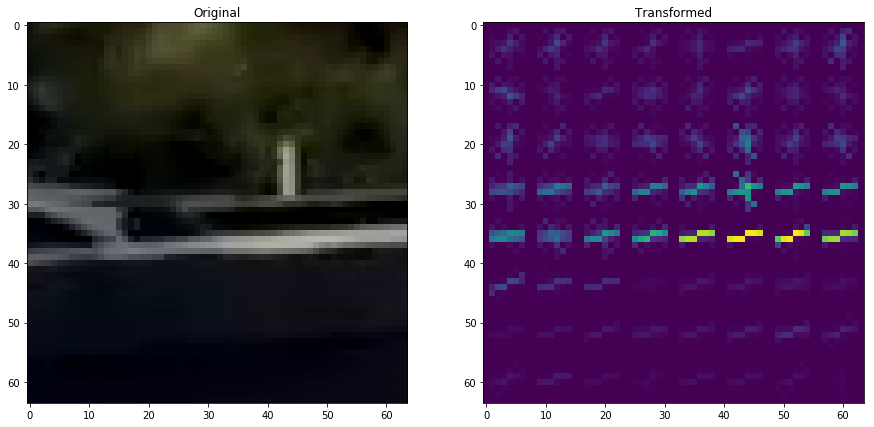

In [177]:
test_img = mpimg.imread('test_images/non-vehicle.png')                              
features, hog_image = get_hog_features(test_img[:,:,2] , vis=True)
show_img(test_img, hog_image)
mpimg.imsave('output_images/non_vehicle_hog.jpg', hog_image)

In [4]:
# Computes binned color features
def bin_spatial(img, size=(32, 32)):
    c1 = cv2.resize(img[:,:,0], size).ravel()
    c2 = cv2.resize(img[:,:,1], size).ravel()
    c3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((c1, c2, c3))

def color_hist(img, nbins=32, bins_range=(0, 256)):
    c1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    c2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    c3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    hist_features = np.concatenate((c1_hist[0], c2_hist[0], c3_hist[0]))
    return hist_features

def extract_features(img, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9, pix_per_cell=8, 
                     cell_per_block=2, hog_channel=0, 
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    if color_space != 'RGB':
        feature_image = convert_color(img, color_space)
    else:
        feature_image = np.copy(img)
    
    file_features = []
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        file_features.append(spatial_features)
        
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        file_features.append(hist_features)
        
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog = get_hog_features(feature_image[:,:,channel],
                                       orient, pix_per_cell, cell_per_block,
                                       vis=False, feature_vec=True)
                hog_features.append(hog)
            hog_features = np.ravel(hog_features)
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        file_features.append(hog_features)
    return np.concatenate(file_features)

### Training

In [154]:
## Configuration to be tweaked
color_space = 'YCrCb' # Supported: YCrCb, HSV, Luv
orient = 13 # HOG Orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2 or 'ALL'
spatial_size = (64, 64) # Spatial binning dimensions
hist_bins = 64 # Number of histogram bins
spatial_feat = True # Enable spatial features
hist_feat = True # Enable histogram features
hog_feat = True # Enable HOG features

In [6]:
def load_and_extract(filename):
    
    img = mpimg.imread(filename)
    features = extract_features(img, color_space=color_space,
                                spatial_size=spatial_size, hist_bins=hist_bins,
                                orient=orient, pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block, hog_channel=hog_channel,
                                spatial_feat=spatial_feat, hist_feat=hist_feat,
                                hog_feat=hog_feat)
    return features

In [155]:
car_training_dir = 'training_images/vehicles/'
car_img_files = glob.glob(car_training_dir + '**/*.png')

car_features = [load_and_extract(f) for f in car_img_files]

In [156]:
non_car_training_dir = 'training_images/non-vehicles/'
non_car_img_files = glob.glob(non_car_training_dir + '**/*.png')

non_car_features = [load_and_extract(f) for f in non_car_img_files]

In [157]:
X = np.vstack((car_features, non_car_features)).astype(np.float64)
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

# define labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(non_car_features))))

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, 
                                                    test_size=0.2, random_state=rand_state)

print('Feature vector length:', len(X_train[0]))
svc = LinearSVC()
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()

print(round(t2-t, 2), 'Seconds to train SVC...')
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
t = time.time()

Feature vector length: 20124
50.54 Seconds to train SVC...
Test Accuracy of SVC =  0.9857


### Detecting Cars from Images

In [11]:
def find_cars(img, ystart, ystop, scale):    
    img = img.astype(np.float32)/255
    tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(tosearch, color_space)
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # calculate blocks for sampling
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1
    nfeat_per_block = orient * cell_per_block**2
    
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2 
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # calculate HOG features per channel
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    detections = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell
            
            # extract image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            test_prediction = svc.predict(test_features)
    
            if test_prediction == 1:
                xbox_left = np.int(xleft * scale)
                ytop_draw = np.int(ytop * scale)
                win_draw = np.int(window * scale)
                detections.append(((xbox_left, ytop_draw+ystart), (xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    
    return detections
    
def draw_detections(img, detections):
    draw_img = np.copy(img)
    for d in detections:
        cv2.rectangle(draw_img, d[0], d[1], (0,0,255), 6)
    return draw_img

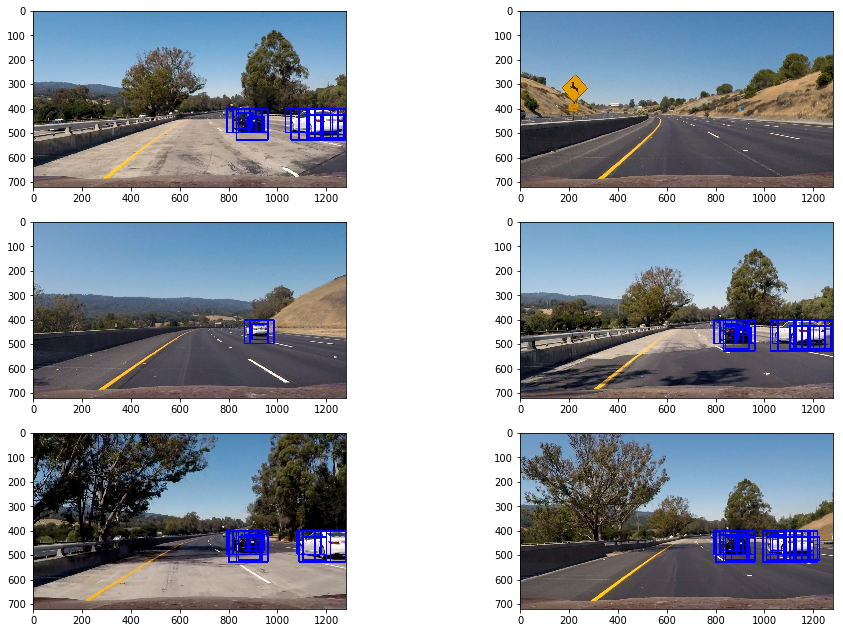

In [180]:
ystart = 400
ystop = 656

grid, axes = plt.subplots(3, 2, figsize=(16, 11))
axes = axes.ravel()

test_imgs = glob.glob('test_images/test*.jpg')
output_imgs = []
for idx, img in enumerate(test_imgs):
    test_img = mpimg.imread(img) 
    detections = []
    detections += find_cars(test_img, ystart, ystop, 1.0)
    detections += find_cars(test_img, ystart, ystop, 1.5)
    detections += find_cars(test_img, ystart, ystop, 2.0)
    out = draw_detections(test_img, detections)
    axes[idx].imshow(out)
    mpimg.imsave('output_images/detections' + str(idx) + '.jpg', out)


### Reducing Multiple Detections

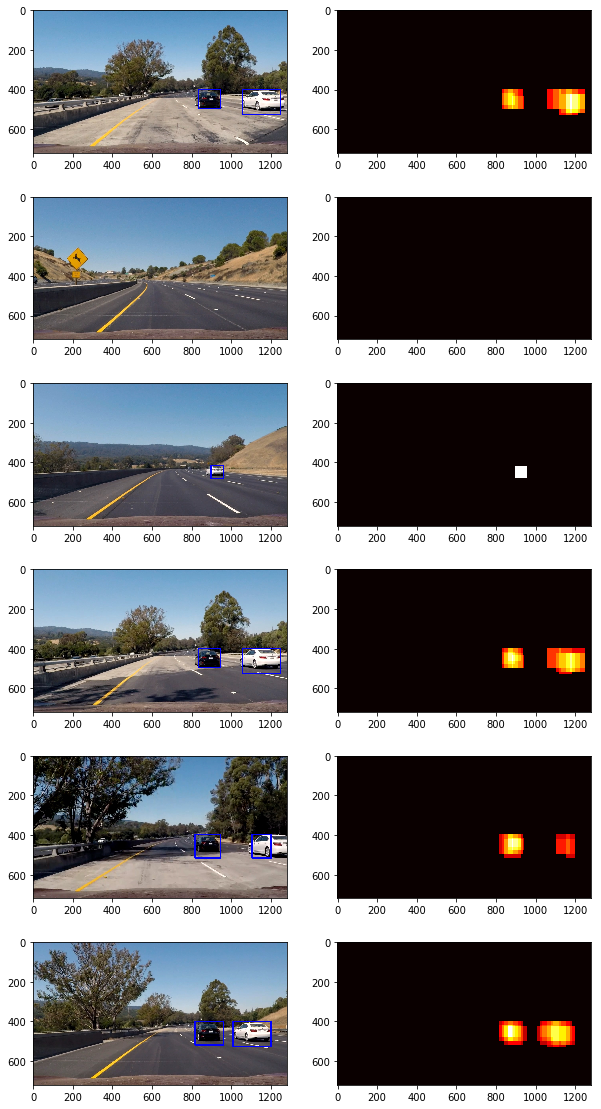

In [187]:
def add_heat(heatmap, detections):
    for d in detections:
        heatmap[d[0][1]:d[1][1], d[0][0]:d[1][0]] += 1
        
    return heatmap

def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

def get_labeled_detections(img, labels):
    detections = []
    for car_num in range(1, labels[1] + 1):
        nonzero = (labels[0] == car_num).nonzero()
        
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        detections.append(bbox)
    return detections

test_imgs = glob.glob('test_images/test*.jpg')
grid, axes = plt.subplots(len(test_imgs), 2, figsize=(10, 20))
axes = axes.ravel()
idx = 0
for img in test_imgs:
    test_img = mpimg.imread(img)
    detections = []
    detections += find_cars(test_img, ystart, ystop, 1.0)
    detections += find_cars(test_img, ystart, ystop, 1.5)
    detections += find_cars(test_img, ystart, ystop, 2.0)  

    heat = np.zeros_like(test_img[:,:,0]).astype(np.float)
    heat = add_heat(heat, detections)
    heat = apply_threshold(heat, 2)

    heatmap = np.clip(heat, 0, 255)
    labels = label(heatmap)
    labeled_detections = get_labeled_detections(test_img, labels)
    draw_img = draw_detections(test_img, labeled_detections)

    axes[idx].imshow(draw_img)
    plt.imsave('output_images/labeled' + str(idx) + '.jpg', draw_img)
    idx += 1

    axes[idx].imshow(heatmap, cmap='hot')
    plt.imsave('output_images/heatmap' + str(idx - 1) + '.jpg', heatmap)
    idx += 1

### Project Video

In [168]:
def pipeline(img):
    global past_heat
    detections = []
    detections += find_cars(img, ystart, ystop, 1.0)
    detections += find_cars(img, ystart, ystop, 1.5)
    detections += find_cars(img, ystart, ystop, 2.0)
        
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat, detections)   
    past_heat.append(heat)
    
    total_heat = np.zeros_like(img[:,:,0]).astype(np.float)
    for past in past_heat:
        total_heat += past
        
    total_heat = apply_threshold(total_heat, 1 + (len(past_heat) // 2))
                
    heatmap = np.clip(total_heat, 0, 255)
    labels = label(heatmap)
    labeled_detections = get_labeled_detections(img, labels)    
    
    return draw_detections(img, labeled_detections)

In [169]:
output_file = 'test_video_out.mp4'
clip = VideoFileClip('test_video.mp4')
past_heat = deque(maxlen=6)
out_clip = clip.fl_image(pipeline)
%time out_clip.write_videofile(output_file, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|█████████▋| 38/39 [01:10<00:01,  1.89s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 1min 8s, sys: 2.71 s, total: 1min 10s
Wall time: 1min 11s


In [178]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_file))

In [165]:
output_file = 'project_video_clip_out.mp4'
clip = VideoFileClip('project_video.mp4').subclip(40.0, 42.0)
past_heat = deque(maxlen=6)
out_clip = clip.fl_image(pipeline)
%time out_clip.write_videofile(output_file, audio=False)

[MoviePy] >>>> Building video project_video_clip_out.mp4
[MoviePy] Writing video project_video_clip_out.mp4


 98%|█████████▊| 50/51 [01:31<00:01,  1.82s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_clip_out.mp4 

CPU times: user 1min 28s, sys: 3.51 s, total: 1min 32s
Wall time: 1min 32s


In [166]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_file))

In [181]:
output_file = 'project_video_out.mp4'
clip = VideoFileClip('project_video.mp4')
past_heat = deque(maxlen=6)
out_clip = clip.fl_image(pipeline)
%time out_clip.write_videofile(output_file, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4



 12%|█▏        | 152/1261 [04:44<36:43,  1.99s/it]


 24%|██▍       | 303/1261 [09:13<27:15,  1.71s/it]


 36%|███▌      | 454/1261 [13:50<24:22,  1.81s/it]


 48%|████▊     | 605/1261 [18:29<21:28,  1.96s/it]


 60%|█████▉    | 756/1261 [23:16<15:22,  1.83s/it]


 72%|███████▏  | 907/1261 [27:48<10:02,  1.70s/it]


 84%|████████▍ | 1057/1261 [32:10<06:08,  1.81s/it]


 96%|█████████▌| 1205/1261 [36:48<01:47,  1.93s/it]


100%|█████████▉| 1260/1261 [38:33<00:01,  1.91s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 37min 25s, sys: 1min 20s, total: 38min 45s
Wall time: 38min 34s


In [183]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_file))